### Applying spline regression to all days of power readings

From previous notebook, we have seen that linear combination of splines and variable transformation helps us formulating regression function for ideal power readings curve for each day. We can apply such spline regression and compare regression coefficients across days. In addition, we can compare total daily energy production across days as well.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
%matplotlib inline

In [25]:
#specify data source 
datasource = 'LocusEnergy'

In [26]:
zipcode = '08641'

In [27]:
datafilename = 'training_data_2.csv'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'

#we can choose which data to look at.
dataDir = mainDir + '/data/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [28]:
data = pd.read_csv(dataDir + datafilename)
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [29]:
#set up output directory
directory = outputDir +'dailyfit' 
if not os.path.exists(directory):
    os.makedirs(directory)
#set up knots 
knots = [-10./12, -8./12, -4./12, 0, 4./12, 8./12, 10./12]
#set up date list and summary table
DateList = list(set(data.tsLocal.map(lambda x: x.date())))
DateList.sort()
dsummary = pd.DataFrame(float('NaN'), index = np.arange(len(DateList)), \
                        columns = ['E','Rsq','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10'])
dsummary['Date']=DateList
#compute necessary quantity for data
x = np.cos(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
y = np.sin(data.azimuth/180*np.pi)*np.cos(data.altitude/180*np.pi)
z = np.sin(data.altitude/180*np.pi)
data['s'] = -y/np.sqrt(y*y+z*z)

#save data after adding variable s
data.to_csv(dataDir + datafilename,index=False)

In [30]:
for i in range(0, len(DateList)): 
    DateOfInterest = DateList[i]
    df = data[data.tsLocal.map(lambda x: x.date()) == DateOfInterest]

    #calculate total daily energy production unit in kWhr
    E = df['power'].sum(skipna=False)*15/60
    dsummary.E.iloc[i] = E
    
    if (not math.isnan(E)):
        x = df.s
        yy = patsy.dmatrix("bs(x, knots = knots, degree=3, include_intercept=True,lower_bound=-1, upper_bound=1) - 1", {"x": x})
        #remove last basis (non-zero at endpoint)
        #y = np.delete(y,-1,1)

        X = yy
        y = df.power

        #add zero for nan
        y[map(math.isnan,y)] = 0

        beta = scipy.optimize.nnls(X,y)[0]
        dsummary.iloc[i,2:13] = beta
        ypredict = np.dot(X,beta)

        confidence = 0.95
        sigmasquare = np.dot(np.dot(X,beta)-y,np.dot(X,beta)-y)/(len(y)-11-1)
        kappa = sp.stats.t._ppf((1+confidence)/2., len(y)-11-1)
        band = kappa*np.sqrt(np.diagonal(np.mat(X)*(np.linalg.inv(np.mat(X.transpose())*np.mat(X))*np.mat(X.transpose())))*sigmasquare)

        Rsq = 1 - np.std(y-ypredict)*np.std(y-ypredict)/(np.std(y)*np.std(y))
        dsummary.Rsq.iloc[i] = Rsq
        '''
        plt.clf()
        plt.plot(x, ypredict,color='black');
        plt.plot(x,y,marker='+', ls='None')
        plt.fill_between(x, ypredict- band, ypredict+ band, color='grey', alpha='0.5')
        plt.title('Date: '+ DateOfInterest.strftime("%Y-%m-%d") + ', E =' + "{:.3f}".format(float(E)) + ', Rsq = '+"{:.3f}".format(float(Rsq)) ) 
        plt.xlabel('s')
        plt.ylabel('normalized power (-)')
        plt.xlim(-1,1)
        plt.ylim(0,1)
        filename = DateOfInterest.strftime("%Y-%m-%d") +'.png'
        plt.savefig(os.path.join(directory, filename))
        '''
        
    

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Once we experiment with degress of polynomial 2, one can see that some fits of power profiles are not smooth at first and last knots. Hence we try degree of polynomials 3 and get better result.

### Criteria to choose data for regression: individual profile consideration

#### Maxima and minima consideration (might be too strong in some cases)

From above investigation, we are now able to see that linear combination of splines is a good candidate for regression function. Now we would like to find ideal coefficients β for any day. From data, we can use regression method as above to find coefficients β. However, we do not know those β's are ideal coefficients or not. So we would like to build criteria to determine if a given measured power profile gives ideal coefficients or not.

One criteria we can use is to consider derivatives of regression function. To have simple bell-shape curve, the power profile curve should have relatively simple variation: increase from zero to maximum then decrease to zero. It just means we expect $\{x|f^\prime(x)=0,f^{\prime\prime}(x)<0 \}$ to have a single member. Also, we expect $\{x|f^\prime(x)=0,f^{\prime\prime}(x) \ge 0 \}$ to be an empty set.

Finding a derivative of linear combination of B-splines degree 3 directly from recursion relation is a tedious task. So we invent a way to find a derivative of such function based on numerical tryouts. We know that function defined between two knots $x \in [k_i, k_{i+1})$ has a form:

$f(x) = a_i x^3 + b_i x^2 + c_i x + d_i$

We may use regression function to predict values for 4 distinct points, say, $\{k_i, \dfrac23k_i + \dfrac13k_{i+1}, \dfrac13k_i + \dfrac23k_{i+1}, k_{i+1}\}$. Then one can solve a system of 4 linear equations with 4 unknowns $\{a_i,b_i,c_i,d_i\}$. Then we can find a derivative of function as:

$f^\prime(x) = 3a_i x^2 + 2b_i x + c_i$

This leads to a simple heurestic as follow: 
1. For each interval between knots, find $\{a_i,b_i,c_i,d_i\}$ as described above.
2. If $(2b_i)^2 - 4(3a_i)(c_i)<0$, i.e., $b_i^2 - 3a_ic_i<0$ then record that the interval has no critical point.
3. Find roots $r = \dfrac{-2b_i \pm \sqrt{(2b_i)^2 - 4(3a_i)(c_i)}}{2 (3a_i)} = \dfrac{-b_i \pm \sqrt{b_i^2 - 3a_ic_i}}{3a_i}$
4. Count the number of roots that lies inside interval between such knots. Such number is number of critical points in the interval.
5. Count total number of critical points of the function. If the total number does not equal one, then we conclude that a given measured power profile does not give ideal coefficients.

Since our construction of splines has non-negative coefficients and zero value at endpoints, if there is one critical point then such critical point is maximum. There is no need to check second derivative.

In [31]:
'''
#read summary file
year = '2013'
zipcode = '92563'
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'
#we can choose which data to look at. For now, we have Locus Energy 2013 or 2014
datasource = '/data/LocusEnergy/'+year+'/'
outputsink = '/output/LocusEnergy/'+year+'/'
directory = mainDir + outputsink + zipcode
dsummary = pd.read_csv(directory+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
'''
[0]

[0]

Here we introduce a number associated of date where winter solstice is zero. This number will be useful in seasonal alignment.

In [32]:
def DOY (timestamp): #Stand for "Day of Year"
    if (type(timestamp) is str):
        if len(timestamp) == 19:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d %H:%M:%S").date()
        if len(timestamp) == 10:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d").date()
    elif (type(timestamp) is datetime.date):
        Date = timestamp
    elif (type(timestamp) is pd.tslib.Timestamp):
        Date= timestamp.date()
    else:
        print 'not valid time object'
    y = str(Date.year)
    NewYear = datetime.datetime.strptime(y+'-01-01',"%Y-%m-%d").date()
    d = (Date - NewYear).days
    if (int(y)%4==0)&(Date > datetime.datetime.strptime(y+'-02-28',"%Y-%m-%d").date()): #leap year correction
        d = d-1
    return d;

def DBW (timestamp): #DBW ("Day Before Winter Solstice")
    d = DOY(timestamp)-355
    if d>0:
        d=d-365
    return d;


In [33]:
dsummary['DBW'] = dsummary.Date.map(lambda x: DBW(x))
#dsummary = dsummary.sort(['DateNum'])

In [34]:
#this will be location of maximum
dsummary['singlemax'] = float('NaN')

#setup knots and check points
knots = [-10./12, -8./12, -4./12, 0, 4./12, 8./12, 10./12]
#intervals share knots. So we need 2*3 (end intervals) + 6*2 (middle intervals) +7 (knots)
xcheck = np.array([-36./36, -34./36, -32./36, -30./36, -28./36, -26./36, -24./36, -20./36, -16./36, -12./36, -8./36, -4./36, 0.,
          4./36, 8./36, 12./36, 16./36, 20./36, 24./36, 26./36, 28./36, 30./36, 32./36, 34./36, 36./36])
y = patsy.dmatrix("bs(x, knots = knots, degree=3, include_intercept=False,lower_bound=-1, upper_bound=1) - 1", {"x": xcheck})
#remove last basis (non-zero at endpoint)
y = np.delete(y,-1,1)
X = y

In [35]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN


In [36]:
for i in range(0, dsummary.shape[0]): 
    if (not math.isnan(dsummary.iloc[i,0])):
        beta = dsummary.iloc[i,2:11]
        ycheck = np.array(np.dot(X,beta))
        Xcheck = pd.DataFrame(1, index = np.arange(len(xcheck)), columns = ['c0','c1','c2','c3'])
        Xcheck.iloc[:,1] = xcheck
        Xcheck.iloc[:,2] = xcheck*xcheck
        Xcheck.iloc[:,3] = xcheck*xcheck*xcheck
        CriticalPoint = float('NaN')
        KickoutLoop = False
        IntervalCount = 0
        while (IntervalCount<8) & (KickoutLoop==False): 
            yshort = ycheck[(3*IntervalCount):(3*IntervalCount+4)]
            Xshort = Xcheck.iloc[(3*IntervalCount):(3*IntervalCount+4),:]
            [d, c, b, a] = np.linalg.solve(Xshort,yshort)
            if b*b-3*a*c >= 0:
                r1 = (-b-np.sqrt(b*b-3*a*c))/(3*a)
                r2 = (-b+np.sqrt(b*b-3*a*c))/(3*a)
                if (r1>=Xshort.iloc[0,1]) & (r1<=Xshort.iloc[3,1]): #check if roots are between knots
                    if math.isnan(CriticalPoint):
                        CriticalPoint = r1
                    else:
                        CriticalPoint = float('NaN')
                        break#KickoutLoop = True #jump off loop
                if (r2>=Xshort.iloc[0,1]) & (r2<=Xshort.iloc[3,1]): #check if roots are between knots
                    if math.isnan(CriticalPoint):
                        CriticalPoint = r2
                    else:
                        CriticalPoint = float('NaN')
                        break#KickoutLoop = True #jump off loop   
            IntervalCount = IntervalCount+1
        dsummary.singlemax[i] = CriticalPoint
    

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


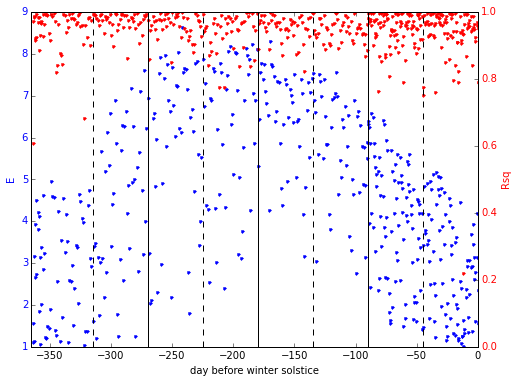

In [37]:
fig, ax1 = plt.subplots()
ax1.plot(dsummary.DBW, dsummary.E, 'b.')
ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(dsummary.DBW, dsummary.Rsq, 'r.')
ax2.set_ylabel('Rsq', color='r')
ax2.set_ylim(0,1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')
plt.xlim(-365,0)

fig = plt.gcf()
fig.set_size_inches(8,6)
#save figure
fig.savefig(outputDir+ '00filter.png',dpi=100)
fig.show()

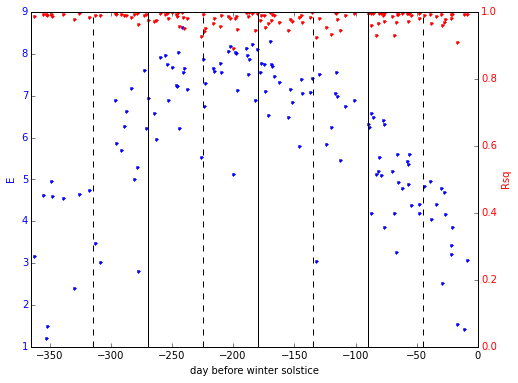

In [38]:
dsummary['PeakCheck'] = dsummary.singlemax.map(lambda x: not math.isnan(x))
dsummary_pickup = dsummary[dsummary.PeakCheck]

fig, ax1 = plt.subplots()
ax1.plot(dsummary.DBW[dsummary.PeakCheck], dsummary.E[dsummary.PeakCheck], 'b.')
ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(dsummary.DBW[dsummary.PeakCheck], dsummary.Rsq[dsummary.PeakCheck], 'r.')
ax2.set_ylabel('Rsq', color='r')
ax2.set_ylim(0,1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')
plt.xlim(-365,0)

fig = plt.gcf()
fig.set_size_inches(8,6)
#save figure
fig.savefig(outputDir + '01filter.png',dpi=100)
fig.show()

Here one can see that the selection method is too strong. We need to find other methods instead.

#### Goodness of the fit consideration (generic and good to use)

Let's look at histogram of Rsq under different seasons (divided by dotted lines).

In [39]:
Rsq_cutoff = 0.95

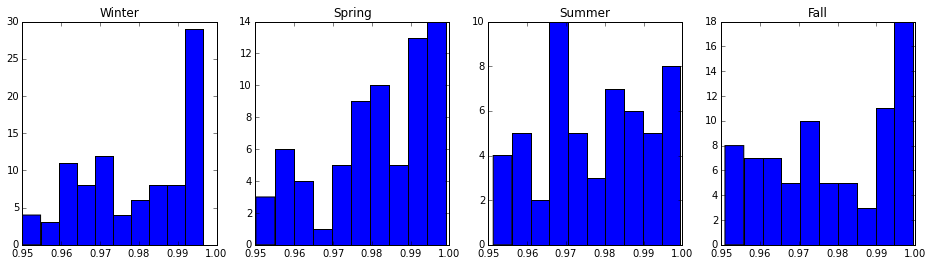

In [40]:
fig = plt.figure(figsize=(16,4))
ax1  = fig.add_subplot(141)
ax1.hist(list(dsummary.Rsq[((dsummary.DBW<=-45-270) | (dsummary.DBW >= -45)) & (dsummary.Rsq>Rsq_cutoff)]))
ax1.set_title('Winter')
ax1  = fig.add_subplot(142)
ax1.hist(list(dsummary.Rsq[(dsummary.DBW<=-45-180) & (dsummary.DBW >= -45-270) & (dsummary.Rsq>Rsq_cutoff)]))
ax1.set_title('Spring')
ax1  = fig.add_subplot(143)
ax1.hist(list(dsummary.Rsq[(dsummary.DBW<=-45-90) & (dsummary.DBW >= -45-180) & (dsummary.Rsq>Rsq_cutoff)]))
ax1.set_title('Summer')
ax1  = fig.add_subplot(144)
ax1.hist(list(dsummary.Rsq[(dsummary.DBW<=-45) & (dsummary.DBW >= -45-90) & (dsummary.Rsq>Rsq_cutoff)]))
ax1.set_title('Fall')

It looks like $Rsq = 0.95$ is a legitimate cutoff. Let's apply it to our data.

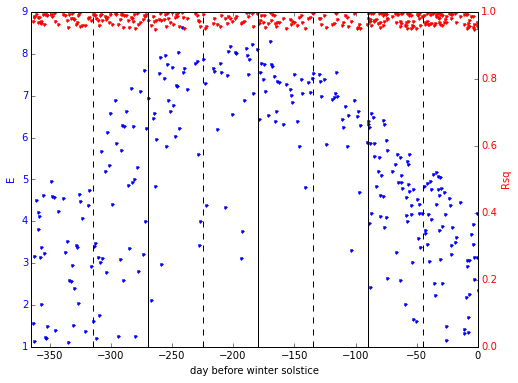

In [41]:
dsummary['FirstCheck'] = dsummary.Rsq.map(lambda x: x> Rsq_cutoff)
dsummary_pickup = dsummary[dsummary.FirstCheck]

fig, ax1 = plt.subplots()
ax1.plot(dsummary.DBW[dsummary.FirstCheck], dsummary.E[dsummary.FirstCheck], 'b.')
ax1.set_xlabel('day before winter solstice')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(dsummary.DBW[dsummary.FirstCheck], dsummary.Rsq[dsummary.FirstCheck], 'r.')
ax2.set_ylabel('Rsq', color='r')
ax2.set_ylim(0,1)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
for i in [-90,-180,-270]:
    plt.axvline(x=i, color='black')
for i in [-45,-45-90,-45-180,-45-270]:
    plt.axvline(x=i, color='black',linestyle='--')
plt.xlim(-365,0)

fig = plt.gcf()
fig.set_size_inches(8,6)
#save figure
fig.savefig(outputDir + '01filter.png',dpi=100)
fig.show()

In [42]:
dsummary.to_csv(outputDir + "/fitsummary_2.csv",index=False)

#### Position of maximum (inaccurate due to flatness of peak)


Another criterion one may use is the position of maximum. Empirically, the position of maximum should vary slowly over days. In addition, the position of maximum should be near zero if symmetry on panels' orientation is assumed. For less-than-a-year data, we use robust linear regression to select data points where the positions of maximum deviate from the regression line by less than $\sin 15^o$ (equivalent to perturbation of our parameter around zero in $1$ hour). For full year data, we may use just can use horizontal line where y-intercept equals median as a regression or apply periodic spline. Let's use periodic spline to do the trick.

In [43]:
'''
import statsmodels.api as sm
x = dsummary_pickup.DateNum
y = patsy.dmatrix("cc(x, df=4)-1", {"x": x})
X = y
y = dsummary_pickup.singlemax
resrlm1 = sm.QuantReg(y, X).fit(q=0.5)

xpredict = x
ypredict1 = resrlm1.predict(patsy.dmatrix("cc(x, df=4, upper_bound = 0, lower_bound = -365)-1", {"x": xpredict}))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="data")
ax.plot(xpredict, ypredict1, 'r-', label="RLM")
legend = ax.legend(loc="best")

for i in ImportantDates:
    plt.axvline(x=(i-DecSolstice).days, color='black')
plt.xlim(-365,0)
'''
[0]

[0]

In [44]:
'''
dsummary_pickup['SecondCheck'] = abs(ypredict1-y)<math.sin(15*math.pi/180)
dsummary['SecondCheck']=False
dsummary.SecondCheck[dsummary_pickup.index]=dsummary_pickup.SecondCheck
dsummary_pickup = dsummary[dsummary.SecondCheck]
'''
[0]

[0]

In [45]:
'''
#dsummary_pickup = dsummary[dsummary.singlemax.map(lambda x: not math.isnan(x))]
fig, ax1 = plt.subplots()
ax1.plot(dsummary.DateNum[dsummary.SecondCheck], dsummary.E[dsummary.SecondCheck], 'b-')
ax1.set_xlabel('time')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('E', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
ax2 = ax1.twinx()
ax2.plot(dsummary_pickup.DateNum[dsummary.SecondCheck], dsummary.Rsq[dsummary.SecondCheck], 'r-')
ax2.set_ylabel('Rsq', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
for i in ImportantDates:
    plt.axvline(x=(i-DecSolstice).days, color='black')
plt.xlim(-365,0)
    
plt.savefig(directory+'/02filter.png')
plt.show()
'''
[0]

[0]

In [46]:
'''float(sum(dsummary.SecondCheck))/dsummary.shape[0]'''[0]

'f'

Using this criterion, one can filter significant number of poor power profiles. For zipcode 08641, about 25-26% of data is retained (for 2013 and 2014). For zipcode [92562, 92563], about [61%, 63%] of data is retained.
